# Import

In [49]:
import pandas as pd
import re
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, Normalizer #,power_transform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import roc_auc_score,classification_report, roc_curve, \
auc,accuracy_score, confusion_matrix, precision_score, log_loss, fbeta_score


# Macros

In [2]:
DATA_FOLDER = '../../data/'
FIG_FOLDER = '../../figures/'

plt.style.use('seaborn-whitegrid')

# Utile Function

## Sklean Pipline Pandas support

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

# Prediction Model

## section data import 

In [8]:
df = pd.read_pickle(DATA_FOLDER + 'clean_pass_01p2_Ptarget_FPemp_ident_clean2.pkl')

## Metric / Score

### Model Metric - main assumtions

Main goal for business 
* Specificity / Selectivity
* try to avoid FP but also get TN right 
* the assumption that you will always find members/borrowers 
* investors are viewer and need to get investment reasons - no FP 

Prediction verfication:
* propability is needed for risk assement
* the estimate must represent similar entropy then ground truth 
* ground truth is not balanced 
* --> cross entropy loss is taken in account to give indication

### Model Performance Overview function

In [17]:
def entropy(y):
    return -((np.sum(y)/ len(y))*np.log(np.sum(y)/ len(y)))
def rate(y):
    return np.sum(y)/ len(y)
    
def Model_Vali(m, X_train, X_test, y_train, y_test, thres=0.5, cm_print= True):
    
    
    y_ins_pred= m.predict(X_train)
    y_outs_pred= m.predict(X_test)
    y_base = np.ones(len(X_test))
    y_base0 = np.zeros(len(X_test))
    try:
        y_ins_pred_p= m.predict_proba(X_train)[:, 1]
        y_outs_pred_p= m.predict_proba(X_test)[:, 1]
        if thres!=0.5:

            y_ins_pred = [1. if e > thres else 0. for e in y_ins_pred_p]
            y_outs_pred = [1. if e > thres else 0. for e in y_outs_pred_p]
    except:
        y_ins_pred_p= y_ins_pred
        y_outs_pred_p= y_ins_pred 
    
    print(f'train pred. rate = {rate(y_ins_pred)}' )
    print(f'train truth rate = {rate(y_train)}' )
    print(f'train truth entropy = {entropy(y_train)}' )
    print(f'train pred. entropy = {entropy(y_ins_pred)}' )
    print(f'test  pred. rate = {rate(y_outs_pred)}' )
    print(f'test  truth rate = {rate(y_test)}' )
    print(f'test  truth entropy = {entropy(y_test)}' )
    print(f'test  pred. entropy = {entropy(y_outs_pred)}' )
    
    print('--')
    print(f'base0  precision = {precision_score(y_test, y_base0)}')
    print(f'base  precision = {precision_score(y_test, y_base)}')
    print(f'test  precision = {precision_score(y_test, y_outs_pred)}')
    print(f'train precision = {precision_score(y_train, y_ins_pred)}')
    print('--')
    print(f'base  ROC-AUC = {roc_auc_score(y_test, y_base)}')
    print(f'test  ROC-AUC = {roc_auc_score(y_test, y_outs_pred)}')
    print(f'train ROC-AUC = {roc_auc_score(y_train, y_ins_pred)}')
    print('--')
    print(f'base  accuracy = {accuracy_score(y_test, y_base)}')
    print(f'test  accuracy = {accuracy_score(y_test, y_outs_pred)}')
    print(f'train accuracy = {accuracy_score(y_train, y_ins_pred)}')
    print('--')
    print(f'base  log_loss = {log_loss(y_test, y_base)}')
    print(f'test  log_loss = {log_loss(y_test, y_outs_pred_p)}')
    print(f'train log_loss = {log_loss(y_train, y_ins_pred_p)}')
    print('--')
    print(f'base  TNR = {TNR(y_test, y_base)}')
    print(f'test  TNR = {TNR(y_test, y_outs_pred)}')
    print(f'train TNR = {TNR(y_train, y_ins_pred)}')
    
    # log_loss
    print('--')
    cm = pd.DataFrame(confusion_matrix(y_test, y_outs_pred), 
                 index=[['actual', 'actual'], ['neg', 'pos']], 
                 columns=[['predicted', 'predicted'], ['neg', 'pos']])
    print('confusion matrix of test')
    display(cm)
    print('--')
    print(classification_report(y_test, y_outs_pred)) 
    
    base_fpr, base_tpr, base_tresh = roc_curve(y_test, y_base)
    test_fpr, test_tpr, test_tresh = roc_curve(y_test, y_outs_pred_p)
    train_fpr, train_tpr, train_tresh = roc_curve(y_train, y_ins_pred_p)
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(test_fpr, test_tpr, 'r', label = 'model-test')
    plt.plot(train_fpr, train_tpr, 'g', label = 'model-train')
    plt.plot(train_fpr, train_tresh, 'k--', label = 'thresh')
    print(len(train_tresh))
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

### Model Performance Overview function - short

In [5]:
def Model_Vali_short(m, X_train, X_test, y_train, y_test, thres=0.5, cm_print=False):
    y_ins_pred= m.predict(X_train)
    y_outs_pred= m.predict(X_test)
    y_base = np.ones(len(X_test))
    y_base0 = np.zeros(len(X_test))
    try:
        y_ins_pred_p= m.predict_proba(X_train)[:, 1]
        y_outs_pred_p= m.predict_proba(X_test)[:, 1]
        if thres!=0.5:

            y_ins_pred = [1. if e > thres else 0. for e in y_ins_pred_p]
            y_outs_pred = [1. if e > thres else 0. for e in y_outs_pred_p]
    except:
        y_ins_pred_p= y_ins_pred
        y_outs_pred_p= y_ins_pred 
        
    print(f'base1 log_loss = {log_loss(y_test, y_base)}')
    print(f'base0 log_loss = {log_loss(y_test, y_base0)}')
    print(f'test  log_loss = {log_loss(y_test, y_outs_pred_p)}')
    print(f'train log_loss = {log_loss(y_train, y_ins_pred_p)}')
    print('--')
    print(f'base1 TNR = {TNR(y_test, y_base)}')
    print(f'base0 TNR = {TNR(y_test, y_base0)}')
    print(f'test  TNR = {TNR(y_test, y_outs_pred)}')
    print(f'train TNR = {TNR(y_train, y_ins_pred)}')
    
    if cm_print:
        cm = pd.DataFrame(confusion_matrix(y_test, y_outs_pred), 
                 index=[['actual', 'actual'], ['neg', 'pos']], 
                 columns=[['predicted', 'predicted'], ['neg', 'pos']])
        
        print('confusion matrix of test')
        display(cm)
    

### Model Performance - Additional Overview

In [80]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

### Core Score function 

In [6]:
def TNR(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)[0, 0] / \
    (confusion_matrix(y_true, y_pred)[0, 1]+confusion_matrix(y_true, y_pred)[0, 0])

def ll(y_true, y_pred):
    return log_loss(y_true, y_pred)

def special_PPV(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred)[1, 1] / \
    (confusion_matrix(y_true, y_pred)[0, 1]*100+confusion_matrix(y_true, y_pred)[1, 1])

## Preprocessing

### feature selection and marking

In [9]:
## All possible features
x_col_all = [
'addr_state',
'annual_inc',
'dti',
'emp_length',
'home_ownership',
'loan_amnt',
'open_acc',
'pub_rec',
'pub_rec_bankruptcies',
'purpose',
'term',
'verification_status',
 'emp_ident']

# Target
y_col = ['target']

## Taken in account features
x_col_select = [
'dti',
'addr_state',
'term',
'annual_inc',
'loan_amnt',
'purpose',
'pub_rec',
'verification_status']
x_col_select = x_col_all
## Taken in account features
df_x = df[x_col_select]
df_y = df[y_col]

In [11]:
df.pub_rec.value_counts()

0.0    36562
1.0     2052
2.0       59
3.0       10
4.0        2
5.0        1
Name: pub_rec, dtype: int64

### Encoding - dummy cration

In [10]:
df_x_encoded = pd.get_dummies(df_x, drop_first=True)
#for i in df_x_encoded.columns:
#    print(i)
df_x_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38686 entries, 1 to 42474
Data columns (total 79 columns):
annual_inc                             38686 non-null float64
dti                                    38686 non-null float64
emp_length                             38686 non-null float64
loan_amnt                              38686 non-null float64
open_acc                               38686 non-null float64
pub_rec                                38686 non-null float64
pub_rec_bankruptcies                   38686 non-null int64
addr_state_AL                          38686 non-null uint8
addr_state_AR                          38686 non-null uint8
addr_state_AZ                          38686 non-null uint8
addr_state_CA                          38686 non-null uint8
addr_state_CO                          38686 non-null uint8
addr_state_CT                          38686 non-null uint8
addr_state_DC                          38686 non-null uint8
addr_state_DE                          

### Toggel the truth

In [18]:
df_y = ~df_y.astype('bool')
df_y = df_y.astype('float')

In [29]:
df_y.target.value_counts(normalize=True)

0.0    0.849765
1.0    0.150235
Name: target, dtype: float64

### Train Test Split

,train,test,all
0.0,0.849778,0.849733,0.849765
1.0,0.150222,0.150267,0.150235


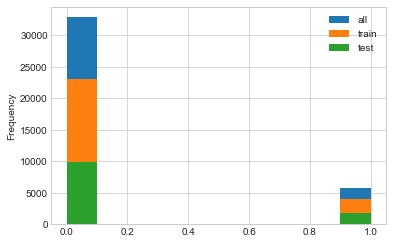

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    df_x_encoded, df_y, test_size=0.3, random_state=25, stratify=df_y)

df_y.target.plot.hist()
y_train.target.plot.hist()
y_test.target.plot.hist()
plt.legend(['all','train','test'])
tts_df = pd.DataFrame()
tts_df['train'] = (y_train.target.value_counts()/y_train.shape[0])
tts_df['test'] = (y_test.target.value_counts()/y_test.shape[0])
tts_df['all'] = (df_y.target.value_counts()/df_y.shape[0])
tts_df

### Transform and Scaling Pipeline

#### simple preproc pipeline

In [31]:
preprocess_pipeline_1 = make_pipeline(
    ColumnSelector(columns=df_x_encoded.columns),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector('float64'),
            StandardScaler()
        )),
        ("bool_features", make_pipeline(
            TypeSelector('int64'),
        )),
        ("dummy_features", make_pipeline(
            TypeSelector('uint8'),
        )),
    ]))

#### individual transform pipeline

In [32]:
# print the scalabels 
print(df_x_encoded.select_dtypes('float').columns)
print(df_x_encoded.select_dtypes('int64').columns)

Index(['annual_inc', 'dti', 'emp_length', 'loan_amnt', 'open_acc', 'pub_rec'], dtype='object')
Index(['pub_rec_bankruptcies'], dtype='object')


In [33]:
preprocess_pipeline_2 = make_pipeline(
    ColumnSelector(columns=df_x_encoded.columns),
    FeatureUnion(transformer_list= [
        ("sel_1",
        make_pipeline(ColumnSelector(columns=['dti' , 'loan_amnt']),
                     FunctionTransformer(lambda x:x),
                     StandardScaler()
                     )),
        ("sel_2",
        make_pipeline(ColumnSelector(columns=['annual_inc']),
                     FunctionTransformer(np.log),
                     MinMaxScaler()
                     )),
        ("sel_3",
        make_pipeline(ColumnSelector(columns=['pub_rec' , 'emp_length', 'open_acc']),
                     FunctionTransformer(lambda x:x),
                     MinMaxScaler()
                     )),
        ("bool_features", 
            make_pipeline(TypeSelector('int64'),
        )),
        ("dummy_features", 
             make_pipeline(TypeSelector('uint8'),
        )),
        ])
        )

In [34]:
t =preprocess_pipeline_2.fit_transform(X_train)
print(t.shape)
print(X_train.shape)

(27080, 79)
(27080, 79)


## Different Models

### Baseline: Logistics Regression

train pred. rate = 0.36665435745937963
train truth rate = 0.1502215657311669
train truth entropy = 0.28476660522087777
train pred. entropy = 0.3678773990637628
test  pred. rate = 0.3691194209891435
test  truth rate = 0.15026710322247114
test  truth entropy = 0.2848073836990488
test  pred. entropy = 0.36787735376836156
--
base0  precision = 0.0
base  precision = 0.15026710322247114
test  precision = 0.2334267040149393
train precision = 0.2317453922852251
--
base  ROC-AUC = 0.5
test  ROC-AUC = 0.6201995798905633
train ROC-AUC = 0.6170774950301677
--
base  accuracy = 0.15026710322247114
test  accuracy = 0.6529381354471825
train accuracy = 0.6530649926144756
--
base  log_loss = 29.349413961439407
test  log_loss = 0.6503867275177484
train log_loss = 0.651238486930639
--
base  TNR = 0.0
test  TNR = 0.6670046643682823
train TNR = 0.6685207717712498
--


/Users/torben/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


confusion matrix of test


predicted      
                 neg   pos
actual neg      6578  3284
       pos       744  1000

--
              precision    recall  f1-score   support

         0.0       0.90      0.67      0.77      9862
         1.0       0.23      0.57      0.33      1744

    accuracy                           0.65     11606
   macro avg       0.57      0.62      0.55     11606
weighted avg       0.80      0.65      0.70     11606

6622


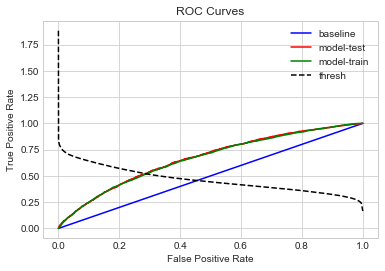

#### --- ####


In [65]:
m1_pipline=Pipeline([('pre',preprocess_pipeline_2), ('M',LogisticRegression(C=0.03, class_weight='balanced' ))])
m1_pipline.fit(X_train,y_train.values.ravel())
Model_Vali(m1_pipline, X_train, X_test, y_train.values, y_test.values, cm_print= True)
print('#### --- ####')
#m1_pipline=Pipeline([('pre',preprocess_pipeline_1), ('M',LogisticRegression(C=0.03, class_weight='balanced' ))])
#m1_pipline.fit(X_train,y_train.values.ravel())
#Model_Vali(m1_pipline, X_train, X_test, y_train, y_test, cm_print= True)

### AdaBoost

train pred. rate = 0.0011078286558345643
train truth rate = 0.1502215657311669
train truth entropy = 0.28476660522087777
train pred. entropy = 0.007539165449073917
test  pred. rate = 0.0013785972772703773
test  truth rate = 0.15026710322247114
test  truth entropy = 0.2848073836990488
test  pred. entropy = 0.009080391194224742
--
base0  precision = 0.0
base  precision = 0.15026710322247114
test  precision = 0.5625
train precision = 0.5666666666666667
--
base  ROC-AUC = 0.5
test  ROC-AUC = 0.5022253776426613
train ROC-AUC = 0.501807017534864
--
base  accuracy = 0.15026710322247114
test  accuracy = 0.8499052214371876
train accuracy = 0.8499261447562777
--
base  log_loss = 29.349413961439407
test  log_loss = 0.6794468882481463
train log_loss = 0.679406615414804
--
base  TNR = 0.0
test  TNR = 0.9992902048266071
train TNR = 0.9994350773509474
--
confusion matrix of test


/Users/torben/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


predicted    
                 neg pos
actual neg      9855   7
       pos      1735   9

--
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92      9862
         1.0       0.56      0.01      0.01      1744

    accuracy                           0.85     11606
   macro avg       0.71      0.50      0.46     11606
weighted avg       0.81      0.85      0.78     11606

6545


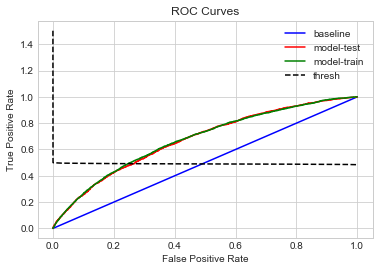

#### --- ####


In [76]:
ada=Pipeline([('pre',preprocess_pipeline_2), 
              ('M',AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=1),
                                      random_state=42))])
ada.fit(X_train,y_train.values.ravel())
Model_Vali(ab_pipeline, X_train, X_test, y_train.values, y_test.values, cm_print= True)
print('#### --- ####')


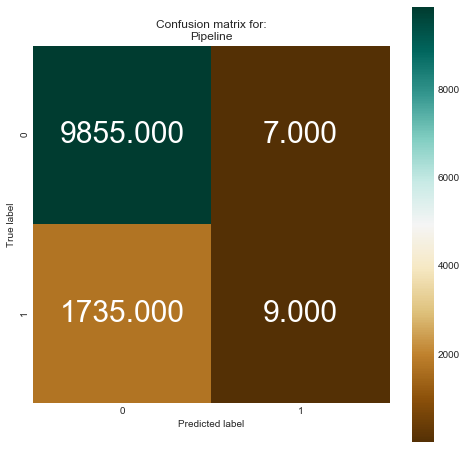

In [77]:
cm = confusion_matrix(y_test, ada.predict(X_test))
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

# view with a heatmap
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='BrBG', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(ada.__class__.__name__));

In [ ]:
evaluate_model(ada.predict_proba(X_train)[:, 1],
        y_outs_pred_p= m.predict_proba(X_test)[:, 1])

In [78]:
y_score = ada.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_score)

0.6741262216756375

In [91]:
# TODO: Initialize the classifier
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier()) 

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators':[50, 120],                
              'learning_rate':[0.1, 0.5, 1.],               
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),               
              'base_estimator__max_depth' : np.arange(1, 4, 1)              
             } 

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(recall_score) 

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = RandomizedSearchCV(estimator=ada, param_distributions=parameters
                              ,scoring=scorer,random_state=42) 

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train.values.ravel()) 

# Get the estimator
best_ada = grid_fit.best_estimator_ 

# Make predictions using the unoptimized and model
predictions = (ada.fit(X_train, y_train)).predict(X_test)
best_predictions = best_ada.predict(X_test) 

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("Accuracy score on testing data: {:.4f}".format(recall_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print(best_ada)

/Users/torben/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Unoptimized model
------
Accuracy score on testing data: 0.7470
F-score on testing data: 0.1931

Optimized Model
------
Final accuracy score on the testing data: 0.8424
Final F-score on the testing data: 0.1263
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         mi

### Support Vector Classifier

In [84]:
from sklearn.svm import SVC

In [93]:
svc = Pipeline([('pre',preprocess_pipeline_2), 
              ('M',SVC(kernel='rbf',random_state=42,class_weight='balanced'))])
svc.fit(X_train,y_train.values.ravel())
Model_Vali(svc, X_train, X_test, y_train.values, y_test.values, cm_print= True)
print('#### --- ####')

train pred. rate = 0.3510709010339734
train truth rate = 0.1502215657311669
train truth entropy = 0.28476660522087777
train pred. entropy = 0.3674894614803873
test  pred. rate = 0.34999138376701705
test  truth rate = 0.15026710322247114
test  truth entropy = 0.2848073836990488
test  pred. entropy = 0.36743731418944753
--
base0  precision = 0.0
base  precision = 0.15026710322247114
test  precision = 0.2397833579517479
train precision = 0.288629430945619
--
base  ROC-AUC = 0.5
test  ROC-AUC = 0.6226825838776957
train ROC-AUC = 0.6903213978735562
--
base  accuracy = 0.15026710322247114
test  accuracy = 0.6675857315181802
train accuracy = 0.7013663220088626
--
base  log_loss = 29.349413961439407


/Users/torben/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: Found input variables with inconsistent numbers of samples: [27080, 11606]

In [ ]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)